In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [2]:
# Basic exploration
staff = pd.read_csv('/kaggle/input/hospital-beds-management/staff.csv')
patients = pd.read_csv('/kaggle/input/hospital-beds-management/patients.csv')
service_weekly = pd.read_csv('/kaggle/input/hospital-beds-management/services_weekly.csv')
staff_schedule = pd.read_csv('/kaggle/input/hospital-beds-management/staff_schedule.csv')

In [3]:
for df, name in zip([staff, patients, service_weekly, staff_schedule],
                    ['staff','patients','service_weekly','staff_schedule']):
    print(f"{name} shape: {df.shape}")
    print(df.info())
    print(df.describe())
    print(df.isna().sum(), '\n')

staff shape: (110, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   staff_id    110 non-null    object
 1   staff_name  110 non-null    object
 2   role        110 non-null    object
 3   service     110 non-null    object
dtypes: object(4)
memory usage: 3.6+ KB
None
            staff_id    staff_name   role service
count            110           110    110     110
unique           110           110      3       4
top     STF-5ca26577  Allison Hill  nurse     ICU
freq               1             1     69      32
staff_id      0
staff_name    0
role          0
service       0
dtype: int64 

patients shape: (1000, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   patient_id      1000 non-null   obje

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


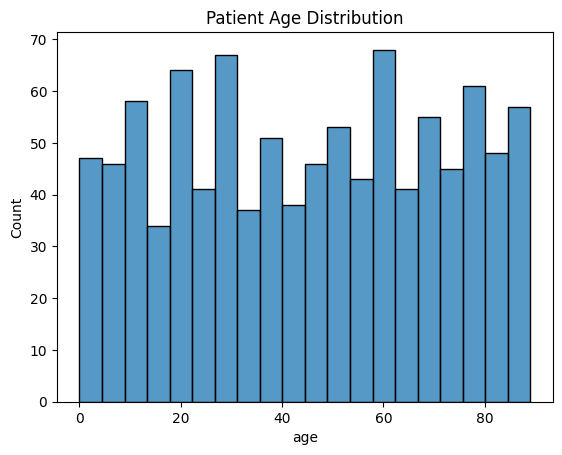

In [4]:
# Look at age distributions
sns.histplot(patients['age'], bins=20)
plt.title("Patient Age Distribution")
plt.show()

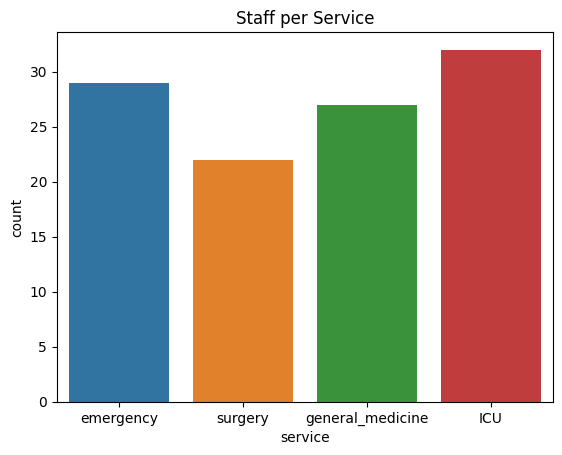

In [5]:
sns.countplot(x='service', data=staff)
plt.title("Staff per Service")
plt.show()

In [6]:
month_distribution = service_weekly.groupby('month')['patients_request'].sum()
month_distribution

month
1     1532
2     1607
3     1176
4     1084
5      778
6      801
7      653
8      686
9      729
10     837
11    1040
12    2570
Name: patients_request, dtype: int64

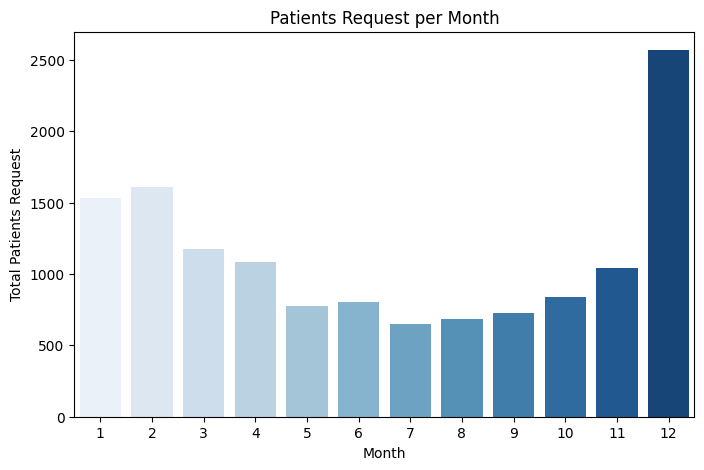

In [7]:
plt.figure(figsize=(8,5))
sns.barplot(x=month_distribution.index, y=month_distribution.values, palette="Blues")
plt.title("Patients Request per Month")
plt.xlabel("Month")
plt.ylabel("Total Patients Request")
plt.show()

In [8]:
event_distribution = service_weekly.groupby(['month','event'])['patients_request'].sum()
event_distribution

month  event   
1      donation       7
       flu          961
       none         564
2      donation     208
       flu          873
       none         506
       strike        20
3      donation     110
       flu          347
       none         719
4      flu          303
       none         753
       strike        28
5      donation     100
       none         583
       strike        95
6      donation     161
       none         619
       strike        21
7      donation      69
       none         584
8      donation      24
       none         647
       strike        15
9      donation      54
       none         644
       strike        31
10     none         721
       strike       116
11     donation      33
       none        1007
12     flu          580
       none        1870
       strike       120
Name: patients_request, dtype: int64

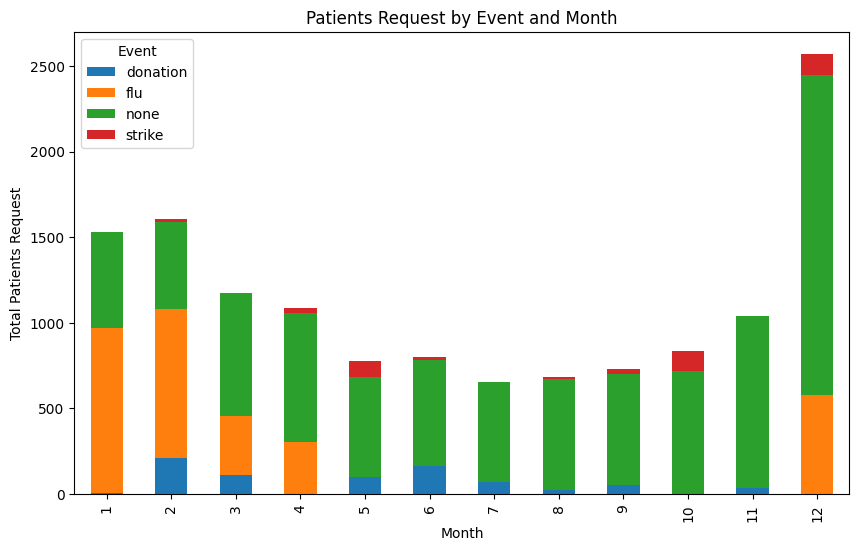

In [9]:
event_distribution = service_weekly.groupby(['month','event'])['patients_request'].sum().reset_index()

pivoted = event_distribution.pivot(index='month', columns='event', values='patients_request')

pivoted.plot(kind='bar', stacked=True, figsize=(10,6))
plt.title("Patients Request by Event and Month")
plt.xlabel("Month")
plt.ylabel("Total Patients Request")
plt.legend(title="Event")
plt.show()

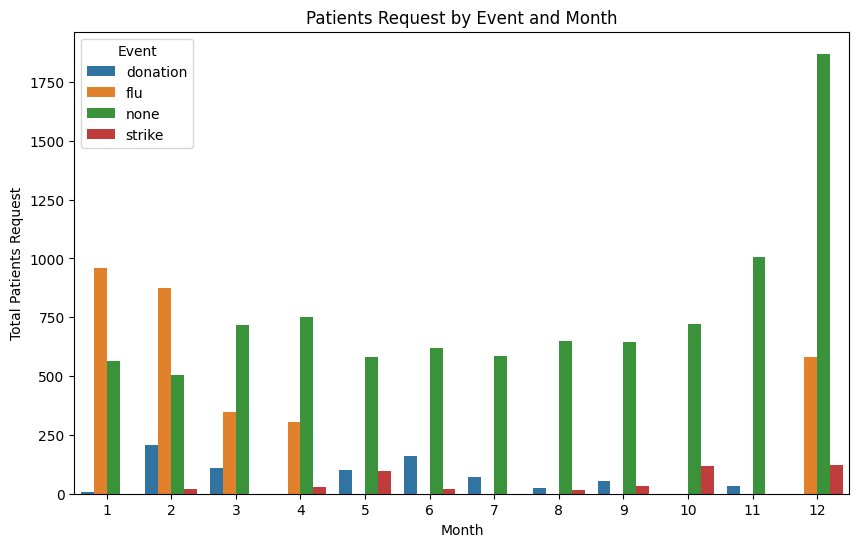

In [10]:
plt.figure(figsize=(10,6))
sns.barplot(data=event_distribution, x='month', y='patients_request', hue='event')
plt.title("Patients Request by Event and Month")
plt.xlabel("Month")
plt.ylabel("Total Patients Request")
plt.legend(title="Event")
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

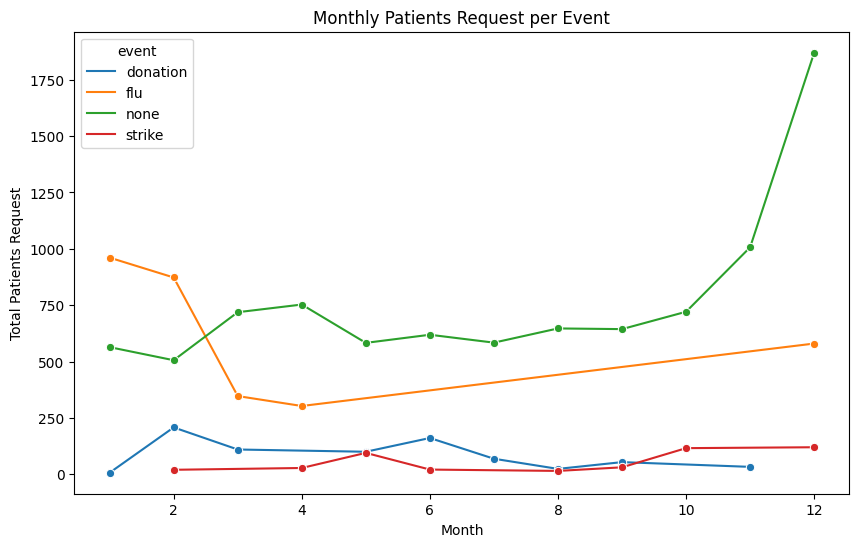

In [11]:
plt.figure(figsize=(10,6))
sns.lineplot(data=event_distribution, x='month', y='patients_request', hue='event', marker="o")
plt.title("Monthly Patients Request per Event")
plt.xlabel("Month")
plt.ylabel("Total Patients Request")
plt.show()

In [12]:
# Refused patients distribution among services
refusal_rate_service = (
    service_weekly
    .groupby('service')[['patients_refused','patients_request']]
    .sum()
)
refusal_rate_service

,patients_refused,patients_request
service,,
ICU,141,789
emergency,5008,6193
general_medicine,1938,4270
surgery,555,2241


In [13]:
refusal_rate_service['refusal_rate'] = (
    refusal_rate_service['patients_refused'] / refusal_rate_service['patients_request']
)
refusal_rate_service=refusal_rate_service['refusal_rate']
refusal_rate_service

service
ICU                 0.178707
emergency           0.808655
general_medicine    0.453864
surgery             0.247657
Name: refusal_rate, dtype: float64

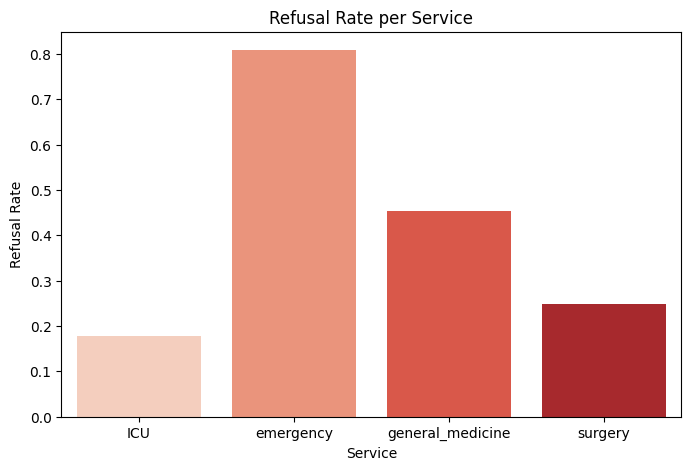

In [14]:
plt.figure(figsize=(8,5))
sns.barplot(x=refusal_rate_service.index, y=refusal_rate_service.values, palette="Reds")
plt.title("Refusal Rate per Service")
plt.xlabel("Service")
plt.ylabel("Refusal Rate")
plt.show()

In [15]:
# Refusal rate by month
service_weekly['refusal_rate'] = service_weekly['patients_refused'] / service_weekly['patients_request']
service_weekly

,week,month,service,available_beds,patients_request,patients_admitted,patients_refused,patient_satisfaction,staff_morale,event,refusal_rate
0,1,1,emergency,32,76,32,44,67,70,none,0.578947
1,1,1,surgery,45,130,45,85,83,78,flu,0.653846
2,1,1,general_medicine,37,201,37,164,97,43,flu,0.815920
3,1,1,ICU,22,31,22,9,84,91,flu,0.290323
4,2,1,emergency,28,169,28,141,75,64,none,0.834320
...,...,...,...,...,...,...,...,...,...,...,...
203,51,12,ICU,18,15,15,0,87,80,none,0.000000
204,52,12,emergency,26,130,26,104,88,63,none,0.800000
205,52,12,surgery,53,39,39,0,82,50,none,0.000000
206,52,12,general_medicine,65,225,65,160,82,40,flu,0.711111


In [16]:
# Add a month column to staff_schedule
staff_schedule['month'] = ((staff_schedule['week'] - 1) // 4 + 1).clip(upper=12)
staff_schedule

,week,staff_id,staff_name,role,service,present,month
0,1,STF-b77cdc60,Allison Hill,doctor,emergency,1,1
1,2,STF-b77cdc60,Allison Hill,doctor,emergency,1,1
2,3,STF-b77cdc60,Allison Hill,doctor,emergency,0,1
3,4,STF-b77cdc60,Allison Hill,doctor,emergency,1,1
4,5,STF-b77cdc60,Allison Hill,doctor,emergency,1,2
...,...,...,...,...,...,...,...
6547,48,STF-302eb752,Erin Edwards,nursing_assistant,ICU,0,12
6548,49,STF-302eb752,Erin Edwards,nursing_assistant,ICU,1,12
6549,50,STF-302eb752,Erin Edwards,nursing_assistant,ICU,1,12
6550,51,STF-302eb752,Erin Edwards,nursing_assistant,ICU,0,12


In [17]:
# Aggregate staff by week & service
staff_by_role = staff_schedule.groupby(['week','month','service','role']).agg(
    staff_count=('staff_id','nunique')
).reset_index()
staff_by_role

,week,month,service,role,staff_count
0,1,1,ICU,doctor,6
1,1,1,ICU,nurse,19
2,1,1,ICU,nursing_assistant,9
3,1,1,emergency,doctor,8
4,1,1,emergency,nurse,22
...,...,...,...,...,...
619,52,12,general_medicine,nurse,16
620,52,12,general_medicine,nursing_assistant,7
621,52,12,surgery,doctor,3
622,52,12,surgery,nurse,16


In [18]:
# Pivot to get separate columns for roles
staff_by_role_pivot = staff_by_role.pivot_table(
    index=['month','service'],
    columns='role',
    values='staff_count',
    aggfunc='mean'
).reset_index().fillna(0)
staff_by_role_pivot

role,month,service,doctor,nurse,nursing_assistant
0,1,ICU,6.0,19.0,9.0
1,1,emergency,8.0,22.0,9.0
2,1,general_medicine,5.0,16.0,7.0
3,1,surgery,3.0,16.0,6.0
4,2,ICU,6.0,19.0,9.0
5,2,emergency,8.0,22.0,9.0
6,2,general_medicine,5.0,16.0,7.0
7,2,surgery,3.0,16.0,6.0
8,3,ICU,6.0,19.0,9.0
9,3,emergency,8.0,22.0,9.0


In [19]:
# Merge two DataFrame
merged_analysis = pd.merge(
    service_weekly,
    staff_by_role_pivot,
    on=['month','service'],
    how='left'
)
merged_analysis

,week,month,service,available_beds,patients_request,patients_admitted,patients_refused,patient_satisfaction,staff_morale,event,refusal_rate,doctor,nurse,nursing_assistant
0,1,1,emergency,32,76,32,44,67,70,none,0.578947,8.0,22.0,9.0
1,1,1,surgery,45,130,45,85,83,78,flu,0.653846,3.0,16.0,6.0
2,1,1,general_medicine,37,201,37,164,97,43,flu,0.815920,5.0,16.0,7.0
3,1,1,ICU,22,31,22,9,84,91,flu,0.290323,6.0,19.0,9.0
4,2,1,emergency,28,169,28,141,75,64,none,0.834320,8.0,22.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,51,12,ICU,18,15,15,0,87,80,none,0.000000,6.0,19.0,9.0
204,52,12,emergency,26,130,26,104,88,63,none,0.800000,8.0,22.0,9.0
205,52,12,surgery,53,39,39,0,82,50,none,0.000000,3.0,16.0,6.0
206,52,12,general_medicine,65,225,65,160,82,40,flu,0.711111,5.0,16.0,7.0


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

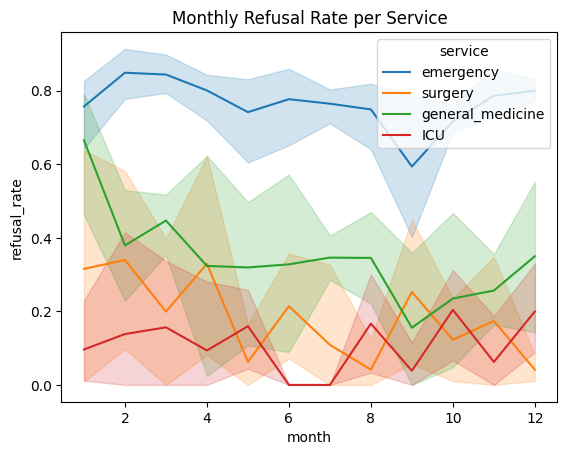

In [20]:
# Hybrid Analysis Workflow
# Refusal rate trends over time per service
sns.lineplot(data=merged_analysis, x="month", y="refusal_rate", hue="service")
plt.title("Monthly Refusal Rate per Service")
plt.show()

In [21]:
# Global Model (big picture)
# Build a multiple linear regression model for refusal rate
merged_analysis['staff_count'] = merged_analysis['doctor'] + merged_analysis['nurse'] + merged_analysis['nursing_assistant']
merged_analysis

,week,month,service,available_beds,patients_request,patients_admitted,patients_refused,patient_satisfaction,staff_morale,event,refusal_rate,doctor,nurse,nursing_assistant,staff_count
0,1,1,emergency,32,76,32,44,67,70,none,0.578947,8.0,22.0,9.0,39.0
1,1,1,surgery,45,130,45,85,83,78,flu,0.653846,3.0,16.0,6.0,25.0
2,1,1,general_medicine,37,201,37,164,97,43,flu,0.815920,5.0,16.0,7.0,28.0
3,1,1,ICU,22,31,22,9,84,91,flu,0.290323,6.0,19.0,9.0,34.0
4,2,1,emergency,28,169,28,141,75,64,none,0.834320,8.0,22.0,9.0,39.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,51,12,ICU,18,15,15,0,87,80,none,0.000000,6.0,19.0,9.0,34.0
204,52,12,emergency,26,130,26,104,88,63,none,0.800000,8.0,22.0,9.0,39.0
205,52,12,surgery,53,39,39,0,82,50,none,0.000000,3.0,16.0,6.0,25.0
206,52,12,general_medicine,65,225,65,160,82,40,flu,0.711111,5.0,16.0,7.0,28.0


In [22]:
ols_formula = "refusal_rate ~ C(month) + C(event) + staff_count + patients_request"
OLS = ols(formula = ols_formula, data=merged_analysis)
model = OLS.fit()
model_results = model.summary()
model_results

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           refusal_rate   R-squared:                       0.712
Model:                            OLS   Adj. R-squared:                  0.688
Method:                 Least Squares   F-statistic:                     29.49
Date:                Sat, 04 Oct 2025   Prob (F-statistic):           4.53e-43
Time:                        16:48:22   Log-Likelihood:                 74.315
No. Observations:                 208   AIC:                            -114.6
Df Residuals:                     191   BIC:                            -57.89
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.4252      0.098     -4.351      0.000      -0.618      -0.232
C(month)[T.2]         -0.0765      0.064     -1.187      0.237      -0.204       0.051
C(month)[T.3]          0.0069      0.066      0.104      0.917      -0.124       0.138
C(month)[T.4]          0.0192      0.065      0.293      0.770      -0.110       0.148
C(month)[T.5]          0.0135      0.067      0.200      0.842      -0.119       0.146
C(month)[T.6]          0.0056      0.067      0.083      0.934      -0.127       0.138
C(month)[T.7]          0.0280      0.067      0.417      0.677      -0.104       0.160
C(month)[T.8]          0.0406      0.067      0.605      0.546      -0.092       0.173
C(month)[T.9]         -0.0352      0.067     -0.525      0.600      -0.168       0.097
C(month)[T.10]         0.0037      0.068      0.055      0.956      -0.129       0.137
C(month)[T.11]        -0.0502      0.067     -0.746      0.456      -0.183       0.083
C(month)[T.12]        -0.0683      0.058     -1.184      0.238      -0.182       0.045
C(event)[T.flu]       -0.1508      0.072     -2.095      0.037      -0.293      -0.009
C(event)[T.none]      -0.0910      0.051     -1.788      0.075      -0.191       0.009
C(event)[T.strike]    -0.0884      0.073     -1.207      0.229      -0.233       0.056
staff_count            0.0200      0.002      8.344      0.000       0.015       0.025
patients_request       0.0038      0.000     14.457      0.000       0.003       0.004
==============================================================================
Omnibus:                        8.671   Durbin-Watson:                   2.206
Prob(Omnibus):                  0.013   Jarque-Bera (JB):               10.924
Skew:                          -0.310   Prob(JB):                      0.00424
Kurtosis:                       3.935   Cond. No.                     1.34e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.34e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### For each additional staff member, refusal_rate increases by 2% (holding others constant).

This is surprising. Normally, more staff should reduce refusals.

Possible explanations:

Staff is being allocated after demand increases (reverse causality).

Staff count is correlated with larger services where refusals are already higher.

### For each additional patient request, refusal_rate increases by 0.38%.

Makes sense: more demand, higher refusals (beds and staff can’t keep up).

Strongest predictor in the model (highest t-value = 14.45).

### Summary interpretation

The regression model explains about 71% of the variation in hospital refusal rates. Patient demand (patients_request) is the strongest driver: more requests lead to higher refusals. Interestingly, staff_count shows a positive correlation with refusal_rate, suggesting staff may be scaled up in response to high-demand weeks rather than preventing refusals. Seasonal effects (month) were not significant, but flu events showed a notable impact.

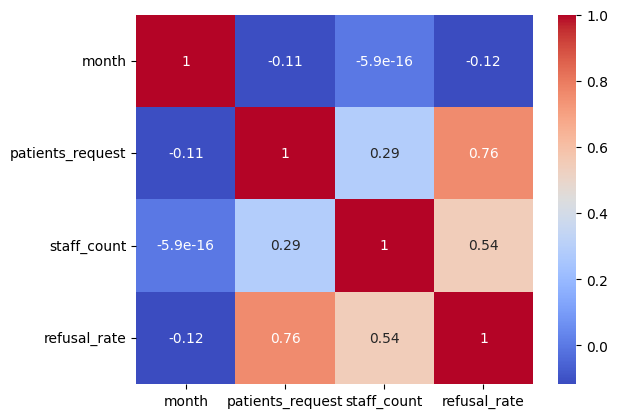

In [23]:
# Check correlations between Month and Patients_request
corr = merged_analysis[['month','patients_request','staff_count','refusal_rate']].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.show()

In [24]:
# Check VIF (Variance Inflation Factor) for multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

X = add_constant(merged_analysis[['month','patients_request','staff_count']])
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)

           Variable        VIF
0             const  38.707338
1             month   1.013226
2  patients_request   1.104072
3       staff_count   1.090846


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

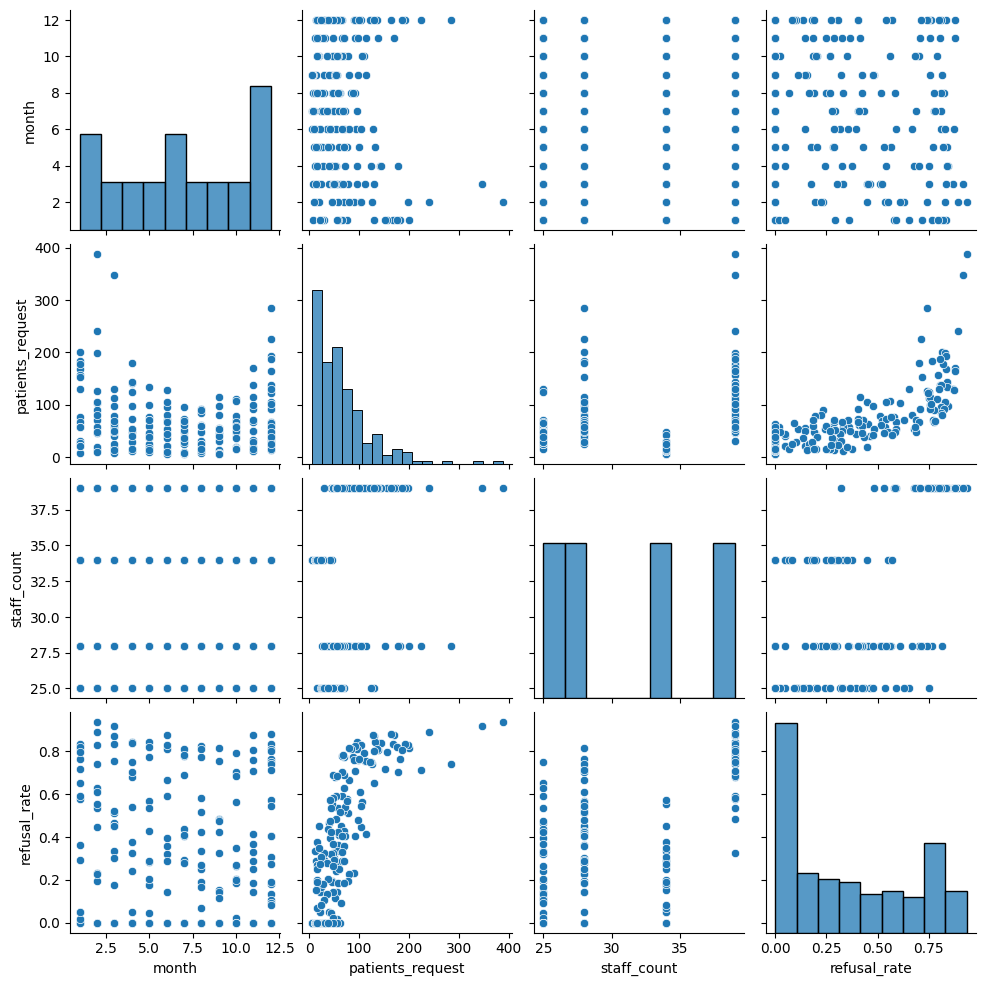

In [25]:
sns.pairplot(merged_analysis[['month','patients_request','staff_count','refusal_rate']])

In [26]:
# Local Models (per service)
results = {}
for service in merged_analysis["service"].unique():
    subset = merged_analysis[merged_analysis["service"] == service]
    
    model = ols(
        "refusal_rate ~ C(month) + C(event) + doctor + nurse + nursing_assistant + patients_request",
        data=subset
    ).fit()
    
    results[service] = model.summary()

In [27]:
# Results for ICU
results["ICU"]

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           refusal_rate   R-squared:                       0.662
Model:                            OLS   Adj. R-squared:                  0.534
Method:                 Least Squares   F-statistic:                     5.171
Date:                Sat, 04 Oct 2025   Prob (F-statistic):           2.99e-05
Time:                        16:48:27   Log-Likelihood:                 50.717
No. Observations:                  52   AIC:                            -71.43
Df Residuals:                      37   BIC:                            -42.16
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.0005      0.000     -2.709      0.010      -0.001      -0.000
C(month)[T.2]         0.0077      0.084      0.092      0.927      -0.162       0.177
C(month)[T.3]         0.1214      0.084      1.451      0.155      -0.048       0.291
C(month)[T.4]         0.0733      0.088      0.836      0.408      -0.104       0.251
C(month)[T.5]         0.1252      0.088      1.424      0.163      -0.053       0.303
C(month)[T.6]         0.0638      0.088      0.727      0.472      -0.114       0.242
C(month)[T.7]         0.0825      0.088      0.936      0.356      -0.096       0.261
C(month)[T.8]         0.1696      0.087      1.941      0.060      -0.007       0.347
C(month)[T.9]         0.1303      0.088      1.473      0.149      -0.049       0.310
C(month)[T.10]        0.1182      0.090      1.320      0.195      -0.063       0.300
C(month)[T.11]        0.0140      0.088      0.158      0.875      -0.165       0.193
C(month)[T.12]        0.0247      0.077      0.322      0.749      -0.131       0.180
C(event)[T.flu]      -0.0681      0.125     -0.543      0.591      -0.322       0.186
C(event)[T.none]      0.0156      0.091      0.170      0.866      -0.170       0.201
doctor               -0.0031      0.001     -2.709      0.010      -0.005      -0.001
nurse                -0.0098      0.004     -2.709      0.010      -0.017      -0.002
nursing_assistant    -0.0047      0.002     -2.709      0.010      -0.008      -0.001
patients_request      0.0187      0.004      5.251      0.000       0.011       0.026
==============================================================================
Omnibus:                        1.062   Durbin-Watson:                   2.044
Prob(Omnibus):                  0.588   Jarque-Bera (JB):                0.494
Skew:                           0.208   Prob(JB):                        0.781
Kurtosis:                       3.235   Cond. No.                     3.55e+19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.03e-35. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### Summary interpretation
In the ICU, refusal rates are primarily driven by patient demand: higher requests sharply increase refusals. Unlike the global model, staff_count plays the expected role here — more staff reduces refusals significantly. Seasonal variation (month) or event has no clear effect. This suggests that in critical units like ICU, staffing flexibility is more effective than trying to anticipate seasonal trends.